[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qiuyi-Hong/SHEMS/blob/main/analysisSHEMS_v4.ipynb)

In [1]:
# # Install necessary packages: 
# !pip install pyomo pandas openpyxl matplotlib jupyter

# # Install cbc solver: 
# !sudo apt-get install  coinor-cbc coinor-libcbc-dev 

# # Download necessary files:
# import urllib.request, sys

# urls = [
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_v3.py',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_v3.dat',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/Simulation%20Results/simulation_results_concatenated.csv',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/agile-half-hour-actual-rates-25-01-2023_26-01-2024.csv',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/simulation_results_completed.csv',
#     ]
# file_names = [url.split('/')[-1] for url in urls]

# for i in range(len(urls)):
#     urllib.request.urlretrieve(urls[i], file_names[i])


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
%matplotlib inline
import pyomo.environ as pyo
from shems import shems_model

# Data Preparation

In [3]:
data = pd.read_csv("simulation_results_completed.csv")
data.head()

,Date,Dry-bulb temperature (°C),Total system energy (kBtu/h),System natural gas (kBtu/h),System electricity (kBtu/h),Total lights energy (kBtu/h),Lights electricity (kBtu/h),Total equip energy (kBtu/h),Equip electricity (kBtu/h),Total CE ex equip (kgCO2/h),...,Electricity (mu),Gas (mu),Renewables (mu),Total nat. gas (kBtu/h),Total electricity (kBtu/h),Total grid displaced elec. PV (kBtu/h),Total energy (kBtu/h),Transformer Losses (kBtu/h),Agile Import price (p/kWh),Agile Export price (p/kWh)
0,2023-01-01 00:00:00,5.5,7.460,7.325,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.325,3.048,0.0,10.372,0.0,4.41,2.77
1,2023-01-01 00:30:00,5.5,7.465,7.330,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.330,3.048,0.0,10.378,0.0,13.91,6.86
2,2023-01-01 01:00:00,5.5,7.468,7.333,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.333,3.048,0.0,10.380,0.0,15.44,7.52
3,2023-01-01 01:30:00,5.5,7.467,7.331,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.331,3.048,0.0,10.379,0.0,1.10,1.34
4,2023-01-01 02:00:00,5.5,7.465,7.330,0.135,0.0,0.0,2.912,2.912,0.5,...,0.06,0.03,0.0,7.330,3.048,0.0,10.378,0.0,6.70,3.76


In [4]:
data.set_index('Date', inplace=True)
# Slice the DataFrame from a start date to the end
start_date = '2023-01-04 00:00:00'
end_date = '2023-01-31 23:30:00'
data = data.loc[start_date:end_date]
data.reset_index(inplace=True)
T = data.shape[0]

# Convert the format of the start date for the figure file name
modified_start_date = start_date.replace(':', '_').replace(' ', '_')

In [5]:
# Solar PV generation
eta = 0.157
S = 20
solar_radiation = data["Direct radiation (W/m²)"]/1000
outdoor_temp = data["Dry-bulb temperature (°C)"]

pv = eta * S * solar_radiation *(1 - 0.005 * (outdoor_temp - 25))

In [6]:
# COP calculation
a = - 0.087
b = 6.8 
COP = a * (outdoor_temp + 30 - outdoor_temp) + b 

In [7]:
delta_t = 0.5

demand_ele = data["Total electricity (kBtu/h)"] * 0.29307107
demand_gas = data["Total nat. gas (kBtu/h)"] * 0.29307107

demand_SH = data["Ap Sys boilers space cond'g load (kW)"]
demand_DHW = data["Ap Sys boilers DHW load (kW)"]
demand_heat = data["Ap Sys boilers load (kW)"][:T]

# Electricity price
ele_import_price = data["Agile Import price (p/kWh)"]
ele_export_price = data["Agile Export price (p/kWh)"]

In [8]:
# Accurate Q_TES_init calculation
T_TES_init = 60
T_inlet = 10
V_TES = 0.3

Q_TES_init = (1000*V_TES*4186*(T_TES_init - T_inlet))/3.6e6
print(Q_TES_init)

# Accurate Q_TES_max calculation
T_TES_max = 70
Q_TES_max = (1000*V_TES*4186*(T_TES_max - T_inlet))/3.6e6
print(Q_TES_max)

17.441666666666666
20.93


In [9]:
inputs = {
    "T": T,
    "delta_t": delta_t,
    "d_ele": demand_ele,
    "d_SH": demand_SH,
    "d_DHW": demand_DHW,
    "pi_import": ele_import_price,
    "pi_export": ele_export_price,
    # ASHP
    "T_out": outdoor_temp,
    "COP": COP,
    "q_HP_max": 10,
    "q_HP_min": 0,
    # Comfort params
    ## For SH
    "rho_in": 1.2041,
    "V_in": 3277,
    "c_in": 1000,
    "T_in_LB": 19,
    "T_in_UB": 23,
    "K_SH": 0.016,
    "T_in_init": 21,
    ## For DHW
    "c_TES": 4186,
    "T_TES_LB": 55,
    "T_TES_UB": 65,
    "K_TES": 0.02,
    "T_TES_init": T_TES_init,
    # TES params
    "Q_TES_min": 0,
    "Q_TES_max": Q_TES_max,
    "Q_TES_init": Q_TES_init,
    "V_TES": V_TES,
    "rho_TES": 1000,
    "T_inlet": T_inlet,
    "T_TES_max": T_TES_max,
    "p_pv": pv
}

# SHEMS

In [10]:
shems = shems_model(inputs)

In [11]:
from sys import platform

if platform == "linux":
    # linux
    solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
elif platform == "darwin":
    # maxOS
    solver = pyo.SolverFactory('cplex', executable = '/Applications/CPLEX_Studio221/cplex/bin/x86-64_osx/cplex')
    # solver = pyo.SolverFactory('scip', solver_io='nl')
    # solver = pyo.SolverFactory('cbc')

solver.solve(shems)

{'Problem': [{'Name': 'tmpg1s1n2rn', 'Lower bound': 35473.275974, 'Upper bound': 35476.69442239021, 'Number of objectives': 1, 'Number of constraints': 30912, 'Number of variables': 17472, 'Number of nonzeros': 57789, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': 7.1, 'Termination condition': 'optimal', 'Termination message': 'MIP - Integer optimal, tolerance (0.0001/1e-06)\\x3a Objective = 3.5476694422e+04', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 2959, 'Number of created subproblems': 2959}}, 'Error rc': 0, 'Time': 7.43159294128418}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
obj_value = pyo.value(shems.obj)
print("Objective function value:", obj_value)

Objective function value: 35476.694422390254


## Visualisation

In [30]:
# Values of decision variables
values = pd.DataFrame(data={'T_TES': [pyo.value(shems.T_TES[t]) for t in range(T)],
                            'q_HP': [pyo.value(shems.q_HP[t]) for t in range(T)],                           
                            'p_HP': [pyo.value(shems.p_HP[t]) for t in range(T)],
                            'q_SH': [pyo.value(shems.q_SH[t]) for t in range(T)],
                            'q_DHW': [pyo.value(shems.q_DHW[t]) for t in range(T)],
                            'T_in': [pyo.value(shems.T_in[t]) for t in range(T)],
                            'epsilon_SH': [pyo.value(shems.epsilon_SH[t]) for t in range(T)],
                            'epsilon_TES': [pyo.value(shems.epsilon_TES[t]) for t in range(T)],
                            'Q_TES': [pyo.value(shems.Q_TES[t]) for t in range(T)],
                            'p_import': [pyo.value(shems.p_import[t]) for t in range(T)],
                            'p_export': [pyo.value(shems.p_export[t]) for t in range(T)],
                            'd_SH': [pyo.value(shems.d_SH[t]) for t in range(T)],
                            'd_DHW': [pyo.value(shems.d_DHW[t]) for t in range(T)]})
                      

In [31]:
values.head()

,T_TES,q_HP,p_HP,q_SH,q_DHW,T_in,epsilon_SH,epsilon_TES,Q_TES,p_import,p_export,d_SH,d_DHW
0,65.000000,5.987233,1.428934,7.105427e-15,5.987233,20.296056,0.305537,1.276000,19.185833,2.322215,0.0,1.2376,1.2229
1,61.518021,0.181057,0.043212,1.810568e-01,0.000000,19.686364,0.295782,1.206360,17.971203,0.936492,0.0,1.2218,1.2229
2,58.300860,0.124411,0.029692,0.000000e+00,0.124411,19.000000,0.288000,1.146017,16.848950,0.922973,0.0,1.2166,1.2229
3,55.000000,3.035357,0.724429,3.035357e+00,0.000000,19.691063,0.299057,1.080000,15.697500,1.617710,0.0,1.2214,1.2229
4,58.303727,4.675875,1.115961,0.000000e+00,4.675875,19.000000,0.289600,1.148075,16.849950,2.009241,0.0,1.2253,1.2229


In [34]:
T_TES = [pyo.value(shems.T_TES[t]) for t in range(T)]
q_HP = [pyo.value(shems.q_HP[t]) for t in range(T)]
p_HP = [pyo.value(shems.p_HP[t]) for t in range(T)]
q_SH = [pyo.value(shems.q_SH[t]) for t in range(T)]
q_DHW = [pyo.value(shems.q_DHW[t]) for t in range(T)]
T_in = [pyo.value(shems.T_in[t]) for t in range(T)]
epsilon_SH = [pyo.value(shems.epsilon_SH[t]) for t in range(T)]
epsilon_TES = [pyo.value(shems.epsilon_TES[t]) for t in range(T)]
Q_TES = [pyo.value(shems.Q_TES[t]) for t in range(T)]
p_import = [pyo.value(shems.p_import[t]) for t in range(T)]
p_export = [pyo.value(shems.p_export[t]) for t in range(T)]

d_ele = [pyo.value(shems.d_ele[t]) for t in range(T)]
d_SH = [pyo.value(shems.d_SH[t]) for t in range(T)]
d_DHW = [pyo.value(shems.d_DHW[t]) for t in range(T)]
p_pv = [pyo.value(shems.p_pv[t]) for t in range(T)]

### Electricity Profile

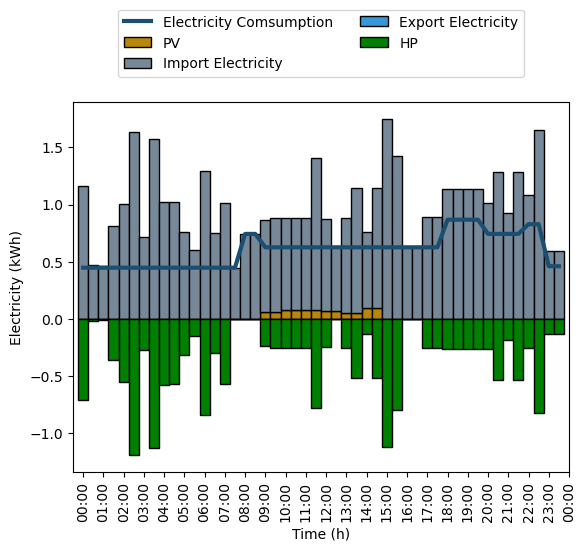

In [35]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(d_ele)*delta_t, label="Electricity Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(p_pv)*delta_t, width=bar_width, label="PV", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(p_import)*delta_t, bottom=np.array(p_pv)*delta_t, width=bar_width, label="Import Electricity", color="#778899", edgecolor="black")

ax1.bar(time_range, np.negative(p_export)*delta_t, width=bar_width, label="Export Electricity", color="#3498DB", edgecolor="black")

ax1.bar(time_range, np.negative(p_HP)*delta_t, bottom=np.negative(p_export)*delta_t, width=bar_width, label="HP", color="#008000", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity (kWh)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/shems_electricity_v4_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Heat Consumption

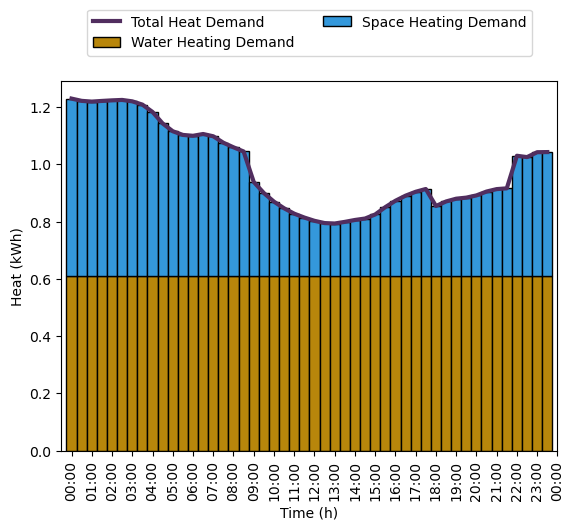

In [36]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(demand_heat)*delta_t, label="Total Heat Demand", color="#512E5F", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(d_DHW)*delta_t, width=bar_width, label="Water Heating Demand", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(d_SH)*delta_t, bottom= np.array(d_DHW)*delta_t, width=bar_width, label="Space Heating Demand", color="#3498DB", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/shems_heat_v4_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### HP Operation

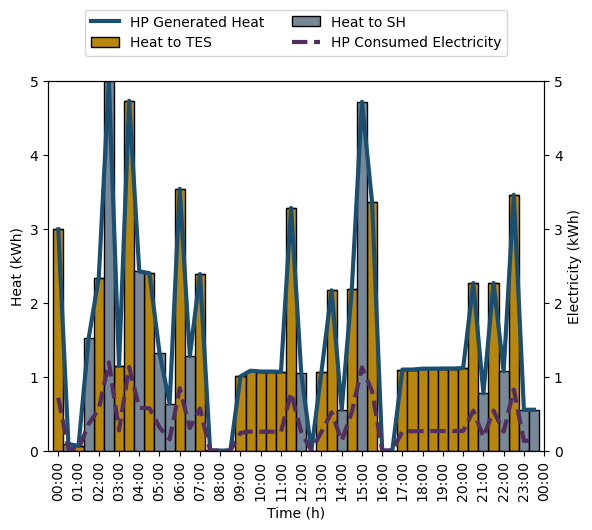

In [37]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(q_HP)*delta_t, label="HP Generated Heat", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(q_DHW)*delta_t, width=bar_width, label="Heat to TES", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(q_SH)*delta_t, bottom=np.array(q_DHW)*delta_t, width=bar_width, label="Heat to SH", color="#778899", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Set the range of the y-axis for ax1
ax1.set_ylim(0, np.max(q_HP)*delta_t)  # Adjust the limits as needed

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(p_HP)*delta_t, label="HP Consumed Electricity", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("Electricity (kWh)")

# Set the range of the y-axis for ax2
ax2.set_ylim(0, np.max(q_HP)*delta_t)  # Adjust the limits as needed

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)
plt.savefig(f"./figures/shems_HP_v4_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### TES Operation

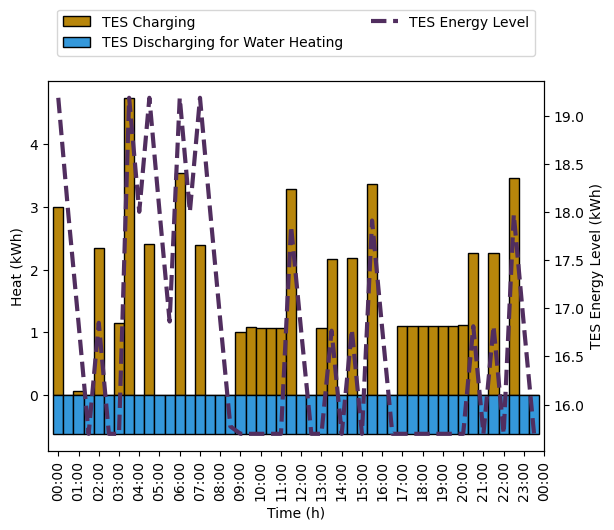

In [38]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

# ax1.plot(time_range, np.array(d_heat), label="Heat Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(q_DHW)*delta_t, width=bar_width, label="TES Charging", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.negative(d_DHW)*delta_t, width=bar_width, label="TES Discharging for Water Heating", color="#3498DB", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(Q_TES), label="TES Energy Level", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("TES Energy Level (kWh)")
# ax2.legend()

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/shems_TES_v4_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Temperature Comfort Control

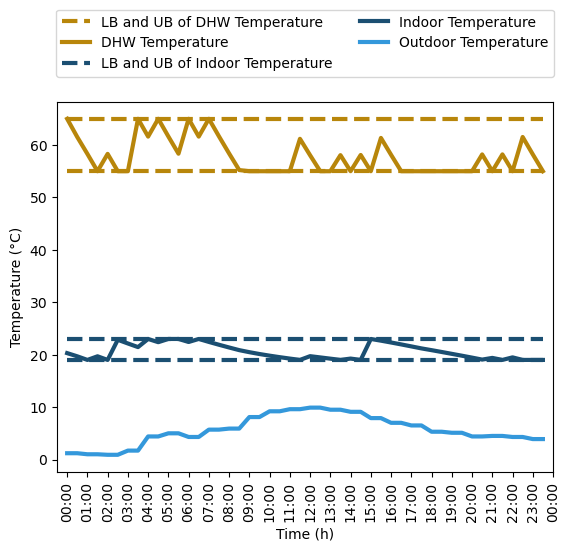

In [41]:
T_TES_LB = shems.T_TES_LB.value
T_TES_UB = shems.T_TES_UB.value

T_in_LB = shems.T_in_LB.value
T_in_UB = shems.T_in_UB.value

T_out = [pyo.value(shems.T_out[t]) for t in range(T)]

fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array([T_TES_UB]*T), label="LB and UB of DHW Temperature", color="#B8860B", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_TES), label="DHW Temperature", color="#B8860B", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array([T_TES_LB]*T), color="#B8860B", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array([T_in_UB]*T), label="LB and UB of Indoor Temperature", color="#1B4F72", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_in), label="Indoor Temperature", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array([T_in_LB]*T), color="#1B4F72", linestyle=lineStyle[2], linewidth=3)

ax1.plot(time_range, np.array(T_out), label="Outdoor Temperature", color="#3498DB", linestyle=lineStyle[0], linewidth=3)

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Temperature (°C)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/shems_temperature_v4_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

### Import & Export Electricity Prices

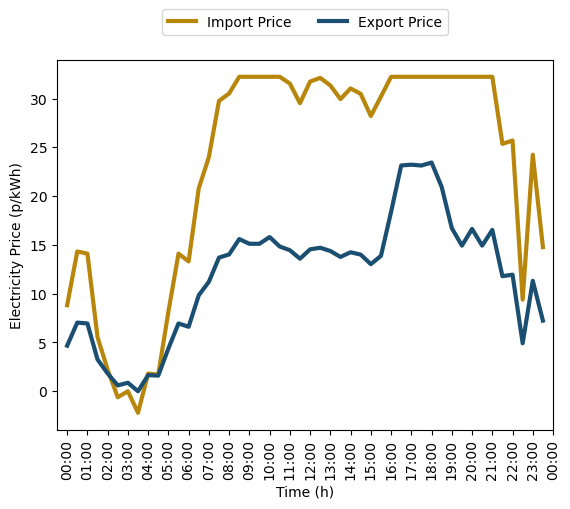

In [43]:
pi_import = [pyo.value(shems.pi_import[t]) for t in range(T)]
pi_export = [pyo.value(shems.pi_export[t]) for t in range(T)]

fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

# Generate a range of datetime objects from 00:00 to 23:30 with half-hourly intervals
start_time = datetime(2023, 1, 1)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=30)*i for i in range(48)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(pi_import), label="Import Price", color="#B8860B", linestyle=lineStyle[0], linewidth=3)

ax1.plot(time_range, np.array(pi_export), label="Export Price", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=30), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity Price (p/kWh)")


# Collect handles and labels
handles1, labels1 = ax1.get_legend_handles_labels()

# Create a single legend
ax1.legend(handles1, labels1, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig(f"./figures/electricity_prices_v4_{modified_start_date}.pdf", bbox_inches='tight')
plt.show()

# Gas Boiler Comparison

In [ ]:
# Jan_Mar_gas_cap = 2153/12000 
# Apr_Jun_gas_cap = 1619/12000
# Jul_Sep_gas_cap = 1007/12000
# Oct_Dec_gas_cap = 935/12000

# avg_gas_cap = (Jan_Mar_gas_cap + Apr_Jun_gas_cap + Jul_Sep_gas_cap + Oct_Dec_gas_cap)/4
# avg_gas_cap

In [13]:
# gas_price = avg_gas_cap * 100

gas_price = 9.59

costs_total_gas = 0

for t in range(T):
    if demand_ele[t] - pv[t] >= 0:
        costs_total_gas += demand_gas[t] * delta_t * gas_price + ele_import_price[t] * (demand_ele[t] - pv[t]) * delta_t
    else:
        costs_total_gas += demand_gas[t] * delta_t * gas_price - ele_export_price[t] * (pv[t] - demand_ele[t]) * delta_t

In [14]:
costs_total_gas

np.float64(37329.91074036186)